<a href="https://colab.research.google.com/github/albertomariapepe/Learning-Rotations/blob/main/LearningRotations_HigherDimension.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/pygae/clifford.git@master

In [ ]:
!pip install tensorflow_graphics

KerasTensor(type_spec=TensorSpec(shape=(None, 25), dtype=tf.float32, name=None), name='dense_7/BiasAdd:0', description="created by layer 'dense_7'")
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 39,577
Trainable params: 39,577
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
733/733 [==============================] - 3s 4ms/step - loss: 0.1085 - val_loss: 0.0308
Epoch 2/200
733/733 [==============================] - 2s 3ms/step - loss: 0.0281 - val_loss: 0.0228
Epoch 3/200
733/733 [==============================] - 2s 3ms/step - loss: 0.0223 - val_loss: 0.0192
Epoch 4/200
733/733 [==============================] - 2s 3ms/step - loss: 0.0184 - val_loss: 0.0167
Epoch 5/200
733/733 [==============================] - 2s 3ms/step - loss: 0.0149 - val_loss: 0.0136
Epoch 6/200
733/733 [==============================] - 2s 3ms

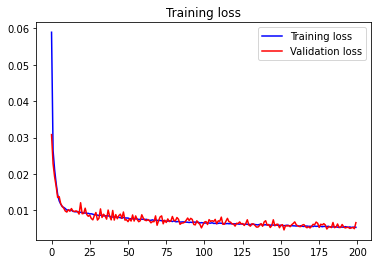

17.912362422340667
3.3820314331118317
4.051213760660136


In [ ]:
from scipy.spatial.transform import Rotation as R
import numpy as np
from clifford.g3c import *
from clifford.tools.g3c import *
from clifford.tools.g3c.rotor_parameterisation import *
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from keras import backend as K
from sklearn.model_selection import train_test_split
from math import acos
import tensorflow as tf
from matplotlib import pyplot as plt
import keras
from math import e, pi
import tensorflow_graphics as tfg
import tensorflow_graphics.geometry.transformation as tfg_transformation

#THESE TWO ARE REQUIRED TO CONVERT TENSOR TO NUMPY ARRAY
#tf.compat.v1.enable_eager_execution()
#tf.config.run_functions_eagerly(True)

#GENERATING THE RANDOM DATASET
tot = int(1e5)
'''
i = 0
from scipy.stats import special_ortho_group

x = []
n = [] 
for i in range(0,tot):

    X = special_ortho_group.rvs(5)

    #print(X)
    #print('----')
    x = np.append(x, X)

    a1 = X[:,0]
    a2 = X[:,1]
    a3 = X[:,2]
    a4 = X[:,3]

    b1 = a1 / np.linalg.norm(a1)

    b2 = a2 - np.dot(a1,b1)*b1
    b2 = b2 / np.linalg.norm(b2)

    b3 = a3 - (np.dot(a3,b1)*b1) - np.dot(a3,b2)*b2
    b3 = b3 / np.linalg.norm(b3)

    b4 = a4 - (np.dot(a4,b1)*b1) - np.dot(a4,b2)*b2 - np.dot(a4,b3)*b3

    e1 = [1, 0, 0, 0, 0]
    e2 = [0, 1, 0, 0, 0]
    e3 = [0, 0, 1, 0, 0]
    e4 = [0, 0, 0, 1, 0]
    e5 = [0, 0, 0, 0, 1]

    b5 = np.zeros(5,)
    b5[0] = np.linalg.det(np.transpose([b1, b2, b3, b4, e1]))
    b5[1] = np.linalg.det(np.transpose([b1, b2, b3, b4, e2]))
    b5[2] = np.linalg.det(np.transpose([b1, b2, b3, b4, e3]))
    b5[3] = np.linalg.det(np.transpose([b1, b2, b3, b4, e4]))
    b5[4] = np.linalg.det(np.transpose([b1, b2, b3, b4, e5]))


    B = np.transpose([b1, b2, b3, b4, b5])

    n = np.append(n, B)
    #n = np.append(n, np.transpose([b3]))

np.save('5D-rotation-matrix.npy', x)
np.save('20D-continuous-repres.npy', n)
'''
x = np.load('5D-rotation-matrix.npy')
n = np.load('20D-continuous-repres.npy')

x = np.reshape(x, [tot, 25])   
n = np.reshape(n, [tot, 25])  

#Train - Test Split
x_train, x_test = train_test_split(x, test_size=0.33, shuffle=False)
n_train, n_test = train_test_split(n, test_size=0.33, shuffle=False)

TRAIN = n_train
TEST = n_test
out_size = 25

nb_epoch = 200
batch_size = 64


r_input = Input(shape=(25))
x = Dense(128)(r_input)
x = LeakyReLU(alpha=0.2)(x)
x = Dense(128)(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dense(128)(x)
x = LeakyReLU(alpha=0.2)(x)
out = Dense(out_size)(x)
print(out)


model = keras.Model(r_input,  out)
model.summary()
model.compile(loss='mae', optimizer="adam")
#es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model_train = model.fit(x = x_train, y = TRAIN, 
                        validation_split=0.3,
                        epochs=nb_epoch,
                        verbose=1,
                        batch_size=batch_size)



loss = model_train.history['loss']
val_loss = model_train.history['val_loss']
epochs = range(nb_epoch)
plt.figure()
plt.plot(epochs, loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Training loss')
plt.legend()
plt.show()

predicted = model.predict(x_test)

M = []
Langle = []

for i in range(0,int(tot*0.33)):
    y_pred = np.reshape(predicted[i], [5, 5])
    y_real = np.reshape(n_test[i], [5, 5])

    M = np.matmul(y_real, np.linalg.inv(y_pred))
    cosine = (M[0,0] + M[1,1] + M[2,2] + M[3,3] + M[4,4]  - 3)/2

    #M = np.dot(y_real,  1/y_pred)
    #cosine = (M - 1)/2
    if cosine > 1:
        cosine = 1
    
    if cosine < -1:
        cosine = -1
    
    #print(acos(cosine))
    Langle = np.append(Langle, acos(cosine))



print(np.max(Langle)*180/pi)
print(np.average(Langle)*180/pi)
print(np.std(Langle)*180/pi)

#np.save('B_loss.npy', loss)
#np.save('B_val_loss.npy', val_loss)
#np.save('B_langle.npy', Langle)


In [ ]:
import numpy as np
from scipy.stats import special_ortho_group

X = special_ortho_group.rvs(5)

a1 = X[:,0]
a2 = X[:,1]
a3 = X[:,2]
a4 = X[:,3]

b1 = a1 / np.linalg.norm(a1)

b2 = a2 - np.dot(a1,b1)*b1
b2 = b2 / np.linalg.norm(b2)

b3 = a3 - (np.dot(a3,b1)*b1) - np.dot(a3,b2)*b2
b3 = b3 / np.linalg.norm(b3)

b4 = a4 - (np.dot(a4,b1)*b1) - np.dot(a4,b2)*b2 - np.dot(a4,b3)*b3


print(n)

In [ ]:
print(i)

In [ ]:
!zip -r /content/ /content

from google.colab import files
files.download("/content/.zip")